# Präsentation der Ergebnisse ( - Welcher Run? - )

#### Libraries

In [1]:
# libraries
import sys
import time
import random
import copy

import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
import numpy as np
from numpy.linalg import inv
from tensorflow.python.ops.gen_array_ops import scatter_nd_eager_fallback
from tensorflow.python.ops.gen_logging_ops import timestamp
import matplotlib.pyplot as plt

Init Plugin
Init Graph Optimizer
Init Kernel


#### Set-Up für Sims:

In [2]:
# Set seed numpy
random.seed(42)
tf.random.set_seed(1234)

# Regressions Fall:

BESCHREIBUNG DES MODELLS HIER.

## Daten Simulieren

Stellschrauben für die Simulation.
n : Anzahl Beobachtungen
k : Anzahl Koeffizienten - Intercept.

### Trainingsdata

In [3]:
n = 100
X = np.random.normal(loc=0.0, scale=1.0, size =n)
X = X.reshape(n, 1)
koef = np.array((3))
koef = koef.reshape(1,1)
noise = np.random.normal(loc=0.0, scale=0.1, size=n)
noise = noise.reshape(n, 1)
y = 1 + np.matmul(X, koef) + noise
y = pd.DataFrame(y)
X = pd.DataFrame(X)

## Hyperparameter u. Rest:

- Differenz (h): 1e-5
- Optimieren über Gradient Descent, daher Batch_size = n


In [4]:
h = 1e-5

In [5]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

## Grundlegendes Modell:

### Modellbeschreibung:
Anzahl Hidden Units : 1

In [6]:
model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(1,  activation='linear', batch_input_shape=(None, 1)))
model0.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt)
model0.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2022-01-20 17:37:36.223498: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-20 17:37:36.223634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
hist = model0.fit(X, y, epochs = 300, batch_size=100, use_multiprocessing=True, verbose=0)

2022-01-20 17:37:36.303726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-20 17:37:36.303924: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-20 17:37:36.381658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


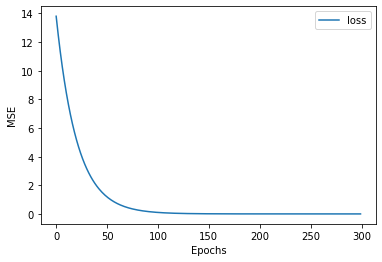

In [8]:
plt.plot(hist.history['loss'])
plt.legend(['loss'])
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

In [9]:
# "Schätzer"
yhat = model0.predict(X)
model0.get_weights()

2022-01-20 17:37:37.331124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[array([[2.9909306]], dtype=float32), array([1.0028119], dtype=float32)]

In [10]:
hist.history['loss'][n - 1]

0.11841607838869095

# Finite Differenzes


### Forward Differences

In [ ]:
y_iter = []
gewichte_mf = [ ] # Forward Gewichte
fits_f = []  # einzelner fit
af_fit = []  # alle fits pro iter.
af_hists = []  # alle histories zum visualisieren des Trainings

In [ ]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] += h
  y_iter.append(temp_y)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1, activation='linear', batch_input_shape=(None, k)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=n, use_multiprocessing=True, verbose=0);
  af_hists.append(hist)
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_mf.append( coefs_m )
  temp_pred = model.predict(X)
  af_fit.append(temp_pred)  # alle y_hats
  fits_f.append(temp_pred[i]); # nur der "eine" y_hat

In [ ]:
plt.plot(hist.history['loss'], label='Training-Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

### Backwards Differences

In [ ]:
y_iter = []
gewichte_mb = [ ] # Forward Gewichte
fits_b = []  # einzelner fit
ab_fit = []  # alle fits pro iter.
ab_hists = []  # alle histories zum visualisieren des Trainings

In [ ]:
%%capture
for i in range(len(X)):
  temp_y = copy.deepcopy(y)
  temp_y.loc[i] -= h
  y_iter.append(temp_y)
  model = tf.keras.Sequential();
  model.add(tf.keras.layers.Dense(1, activation='linear', batch_input_shape=(None, k)));
  model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=opt);
  hist = model.fit(X, temp_y, epochs = 300, batch_size=n, use_multiprocessing=True, verbose=0);
  ab_hists.append(hist)
  coefs_m = np.vstack((model.get_weights()[0]))
  gewichte_mb.append( coefs_m )
  temp_pred = model.predict(X)
  ab_fit.append(temp_pred)  # alle y_hats
  fits_b.append(temp_pred[i]); # nur der "eine" y_hat

In [ ]:
plt.plot(hist.history['loss'], label='Training-Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

## Analyse

Ablauf: 
  - Forward Difffs
  - Backward Diffs
  - Centered Diffs

Anschauen:
  - Ergebnisse
  - Wenn "komische" dann,
    - y_hats einzelt,
    - y_hats der jeweiligen Iteration
    - die trainings history der Iteration anschauen

#### Forward Diffs:

In [ ]:
np.sum((fits_f - yhat) / h)

#### Backward Diffs:

In [ ]:
np.sum((yhat - fits_b) / h)

#### Centred Diffs:

In [ ]:
np.sum((fits_f - fits_b) / (2 * h))